# Reaction Networks

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *
from functools import reduce 

%matplotlib inline

init_printing(use_latex='mathjax')

# Deterministic Reaction Networks

def StoichiometricMatix(rxns):
    """Returns the stoichiometric matrix for the given reactions.
       It is assumed that the reactions are in a list of reactions
       each ofthe form
          [ar, ap, rate_constant]
       where ar is the reactant vector and ap is the product vector.
    """
    vectors = [(-Matrix(a[0]) + Matrix(a[1])) for a in rxns]
    A = Matrix(vectors[0])
    for i in range(1,len(vectors)):
        A = A.col_insert(i,vectors[i])
    return A

def MAK(a,species):
    """The mass action kinetics rate for the reaction a [ ar, ap, k ].
       syms should be a list of sympy symbols such as returned by var("x y z")"""
    rate = a[2] # k
    for r,s in zip(a[0],species):
        rate = rate * s**r
    return rate

def KineticsVector(rxns,species):
    """Builds the kinetics vector for the given reactions"""
    return Matrix([MAK(a,species) for a in rxns])

def Dynamics(rxns,species):
    """Builds the right hand side of the equation dv/dt = AK(v)"""
    return StoichiometricMatix(rxns) * KineticsVector(rxns,species)

def ODEs(dynamics,species):
    """Convertns the dynamics into a function that can be used with scipy's odeint function"""
    faux = lambdify([species],dynamics,'numpy')
    def f(x,t):
        return faux(x).flatten()
    return f

def vectorize(species,names):
    a = [0 for s in species]
    for name in names:
        a[species.index(name)] += 1
    return a

def make_vectorizer(species):
    def f(*args):
        return vectorize(species, args)
    return f

# Stochastic Networks

In [543]:
class ReactionNetwork:
    
    def __init__(self,names):
        self.names = names
        self.n = len(self.names)
        self.species = var(names)
        self.m = self.moment_vector()
        self.rxns = []
        
    def vectorize(self,parts):
        a = [0 for s in self.species]
        for part in parts:
            a[self.species.index(part)] += 1
        return a

    def make_vectorizer(self):
        def f(*args):
            return self.vectorize(args)
        return f        

    def moment_vector(self):
        m = [var("m_" + name) for name in self.names]
        for i in range(self.n):
            for j in range(i+1):
                m.append(var("m_" + self.names[i] + self.names[j]))
        return m

    def sublist(self):
        s = []
        for i in range(self.n):
            for j in range(i+1):
                s.append((
                    self.species[i]*self.species[j], 
                    var("m_" + self.names[i] + self.names[j]))
                )
        for i in range(self.n): # Note first moments come last so that second moments 
                                # are substituted first
            s.append((
                self.species[i],
                var("m_" + self.names[i]))
            )
        return s

    def first_power_vector(self,i):
        return [ (1 if i == j else 0) for j in range(self.n)]

    def second_power_vector(self,i,j):
        v = [0 for i in range(self.n)]
        v[i] += 1
        v[j] += 1
        return v

    def moment(self,powers):
        def f(species):
            terms = [s**p for s,p in zip(species,powers)]
            return reduce((lambda x, y: x * y), terms)
        return f

    def next(self, rxn, state):
        return Matrix(state) - Matrix(rxn[0]) + Matrix(rxn[1])
    
    def MAK(a):
        """The mass action kinetics rate for the reaction a [ ar, ap, k ].
           syms should be a list of sympy symbols such as returned by var("x y z")"""
        rate = a[2] # k
        for r,s in zip(a[0],self.species):
            rate = rate * s**r
        return rate    
    
    def extended_generator(self,f):
        state = self.species # symbolic representation of the state
        terms = [
            (f(self.next(rxn, state)) - f(Matrix(state))) * self.MAK(rxn) 
            for rxn in self.rxns
        ]
        return sum(terms).simplify()

    def first_moment_equations(self):
        return [ 
            self.extended_generator(
                self.moment(self.first_power_vector(i))
            ).subs(self.sublist()) 
            for i in range(self.n) 
        ]

    def second_moment_equations(self):
        eqns = []
        for i in range(self.n):
            for j in range(i+1):
                eqns.append(
                    self.extended_generator(
                        self.moment(self.second_power_vector(i,j))
                    ).subs(self.sublist())                 
                )
        return eqns

    def moment_equations(self):
        return Matrix(self.first_moment_equations() + self.second_moment_equations())

    def moment_odes(self,params):
        eqns = self.moment_equations()
        eqns = [eqn.subs(params) for eqn in eqns]
        dmdt = lambdify([self.m], eqns, 'numpy')
        def f(x,t):
            return dmdt(x)
        return f
    
    def next_states(self,state,params=[]):
        return [(self.next(rxn,state),MAK(rxn,state).subs(params)) for rxn in self.rxns if MAK(rxn,state).subs(params) > 0]
    
    def total_rate_out(self,state,params=[]):
        ns = self.next_states(state,params)
        return sum([k[1] for k in ns])
    
    def choose_next(self,state,params):
        ns = self.next_states(state,params)
        r = self.total_rate_out(state,params) * np.random.random()
        i = 0
        s = ns[0][1]
        while r > s:
            i = i + 1
            s = s + ns[i][1]
        return ns[i][0]
    
    def choose_time(self,state,params):
        K = self.total_rate_out(state,params)
        r = np.random.random()
        return (1/K) * log(1/(1-r))
    
    def ssa(self,x0,tmax,params):
        x = x0
        t = 0
        xdata = [x0]
        tdata = [t]
        while t < tmax and len(self.next_states(x,params)) > 0:
            xnew = self.choose_next(x,params)
            dt = self.choose_time(x,params)
            x = xnew
            t = t + dt
            xdata.append(x)
            tdata.append(t)
        return np.array(tdata),np.array(xdata) 
        

# Example

In [460]:
system = ReactionNetwork(["R", "P"])
params = var("k1 k2 k3 k4")
params = [ (k1,4), (k2,0.25), (k3,1), (k4,0.1) ]
v = system.make_vectorizer()

system.rxns = [   
    [v(), v(R), k1],           # 0 -> R
    [v(R), v(), k2],           # R -> 0
    [v(R), v(R,P), k3],        # R -> R + P
    [v(P), v(), k4]            # P -> 0 
]

eqns = system.moment_equations()
eqns

⎡              k₁ - k₂⋅m_R              ⎤
⎢                                       ⎥
⎢            k₃⋅m_R - k₄⋅m_P            ⎥
⎢                                       ⎥
⎢  2⋅k₁⋅m_R + k₁ + k₂⋅m_R - 2⋅k₂⋅m_RR   ⎥
⎢                                       ⎥
⎢ k₁⋅m_P - k₂⋅m_PR + k₃⋅m_RR - k₄⋅m_PR  ⎥
⎢                                       ⎥
⎣2⋅k₃⋅m_PR + k₃⋅m_R + k₄⋅m_P - 2⋅k₄⋅m_PP⎦

In [461]:
equilibrium = solve(eqns,system.m)
equilibrium

⎧                        ⎛                        2                      2⎞   
⎪     k₁⋅k₃        k₁⋅k₃⋅⎝k₁⋅k₂⋅k₃ + k₁⋅k₃⋅k₄ + k₂ ⋅k₄ + k₂⋅k₃⋅k₄ + k₂⋅k₄ ⎠   
⎨m_P: ─────, m_PP: ────────────────────────────────────────────────────────, m
⎪     k₂⋅k₄                             2   2                                 
⎩                                     k₂ ⋅k₄ ⋅(k₂ + k₄)                       

                                                               ⎫
     k₁⋅k₃⋅(k₁⋅k₂ + k₁⋅k₄ + k₂⋅k₄)       k₁        k₁⋅(k₁ + k₂)⎪
_PR: ─────────────────────────────, m_R: ──, m_RR: ────────────⎬
              2                          k₂              2     ⎪
            k₂ ⋅k₄⋅(k₂ + k₄)                           k₂      ⎭

In [462]:
eq = Matrix(system.m).subs(equilibrium).subs(params)
eq

⎡      16.0      ⎤
⎢                ⎥
⎢     160.0      ⎥
⎢                ⎥
⎢     272.0      ⎥
⎢                ⎥
⎢2605.71428571429⎥
⎢                ⎥
⎣26217.1428571429⎦

In [463]:
m_R.subs(equilibrium).simplify(), (m_RR - m_R**2).subs(equilibrium).simplify()

⎛k₁  k₁⎞
⎜──, ──⎟
⎝k₂  k₂⎠

In [464]:
m_P.subs(equilibrium).simplify(), (m_PP - m_P**2).subs(equilibrium).simplify()

⎛k₁⋅k₃  k₁⋅k₃⋅(k₂ + k₃ + k₄)⎞
⎜─────, ────────────────────⎟
⎝k₂⋅k₄    k₂⋅k₄⋅(k₂ + k₄)   ⎠

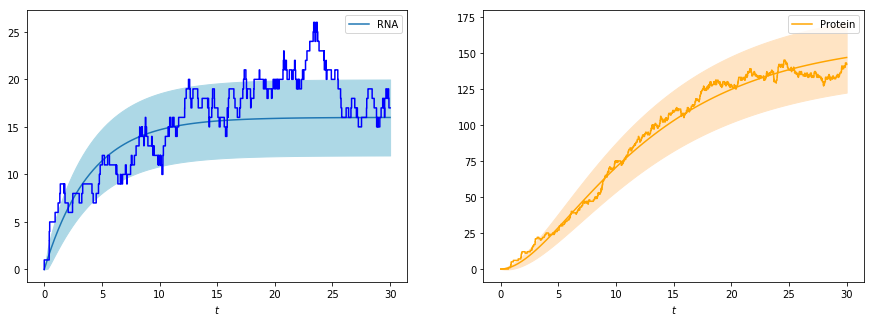

In [465]:
dmdt = system.moment_odes(params)
tmax = 30
t = np.linspace(0,tmax,100)
m0 = [0,0,0,0,0]
m = spi.odeint(dmdt,m0,t)

rstdev = np.sqrt(m[:,2]-m[:,0]**2)
pstdev = np.sqrt(m[:,4]-m[:,1]**2)

ssa_t,ssa_x = system.ssa([0,0],tmax,params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(t,m[:,0],label="RNA")
ax[0].step(ssa_t,ssa_x[:,0],color="blue")
ax[0].fill_between(t,m[:,0] - rstdev,m[:,0] + rstdev,color="lightblue");
ax[0].set_xlabel("$t$")

ax[1].plot(t,m[:,1],label="Protein",color="orange")
ax[1].step(ssa_t,ssa_x[:,1],color="orange")
ax[1].fill_between(t,m[:,1] - pstdev,m[:,1] + pstdev,color="bisque");
ax[1].set_xlabel("$t$")

ax[0].legend();
ax[1].legend();

In [466]:
system.next_states([50,0],params)

⎡⎛⎡51⎤, 4⎞, ⎛⎡49⎤, 12.5⎞, ⎛⎡50⎤, 50⎞⎤
⎢⎜⎢  ⎥   ⎟  ⎜⎢  ⎥      ⎟  ⎜⎢  ⎥    ⎟⎥
⎣⎝⎣0 ⎦   ⎠  ⎝⎣0 ⎦      ⎠  ⎝⎣1 ⎦    ⎠⎦

In [467]:
system.total_rate_out([50,0],params)

66.5000000000000

In [468]:
[system.choose_next([50,0],params) for i in range(10)]

⎡⎡50⎤, ⎡49⎤, ⎡49⎤, ⎡50⎤, ⎡50⎤, ⎡50⎤, ⎡50⎤, ⎡50⎤, ⎡50⎤, ⎡50⎤⎤
⎢⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎣⎣1 ⎦  ⎣0 ⎦  ⎣0 ⎦  ⎣1 ⎦  ⎣1 ⎦  ⎣1 ⎦  ⎣1 ⎦  ⎣1 ⎦  ⎣1 ⎦  ⎣1 ⎦⎦

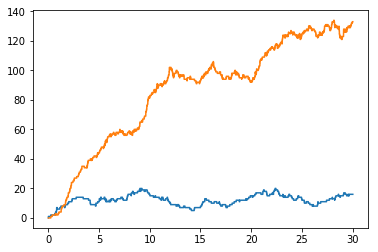

In [469]:
t,x = system.ssa([0,0],30,params)
plt.step(t,x);

# Enzyme Kinetics

In [542]:
system = ReactionNetwork(["E", "S", "X", "P"])
params = var("k1 k2 k3")
params = [ (k1,1), (k2,0.5), (k3,.1) ]
v = system.make_vectorizer()

system.rxns = [   
    [v(E,S), v(X), k1], 
    [v(X), v(E,S), k2],      
    [v(X), v(E,P), k3]
]

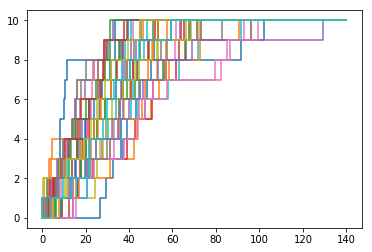

In [541]:
for i in range(40):
    ssa_t,ssa_x = system.ssa([2,10,0,0],140,params)
    ssa_t = np.append(ssa_t,140)
    ssa_x = np.append(ssa_x,[[2,0,0,10]],axis=0)
    plt.step(ssa_t, ssa_x[:,3]);

# Multiplication

In [549]:
multiplier = ReactionNetwork([
    "S0", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", 
    "R0", "R1", "R2"
])

params = var("k e")
params = [ (k,1), (e,0.01) ]

multiplier.species

[S₀, S₁, S₂, S₃, S₄, S₅, S₆, S₇, S₈, R₀, R₁, R₂]

In [ ]:
v = multiplier.make_vectorizer()

multiplier.rxns = [
    [v(S0,R0), v(S1), k],    # dec(0,0,1,8)
    [v(S0),    v(S8), e],    
    [v(S1,R1), v(S2), k],    # dec(1,1,2,4)
    [v(S1),    v(S4), e],         
]